newnetwork3_cnn.ipynb

PyTorch Cifar10 classifier is used under convolutional neural network. Its performance is much better than traditional neural network in recognition of 3D R-G-B mode of cifar10 images.

In [1]:
# Import the libraries

import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Load the data

# Number of subprocesses to use for data loading
num_workers = 0

# How many samples per batch to load
batch_size = 20

# Convert data to a normalized torch.FloatTensor
transform = transforms.Compose([transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                transforms.RandomRotation(10), transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Select training_set and testing_set
train_data = datasets.CIFAR10(root='./data', train= True, download=True, transform = transform)
test_data = datasets.CIFAR10(root='./data', train= False, download=True, transform = transform)

# Prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)

# Specify the image classes
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


100%|██████████| 170M/170M [00:02<00:00, 74.6MB/s]


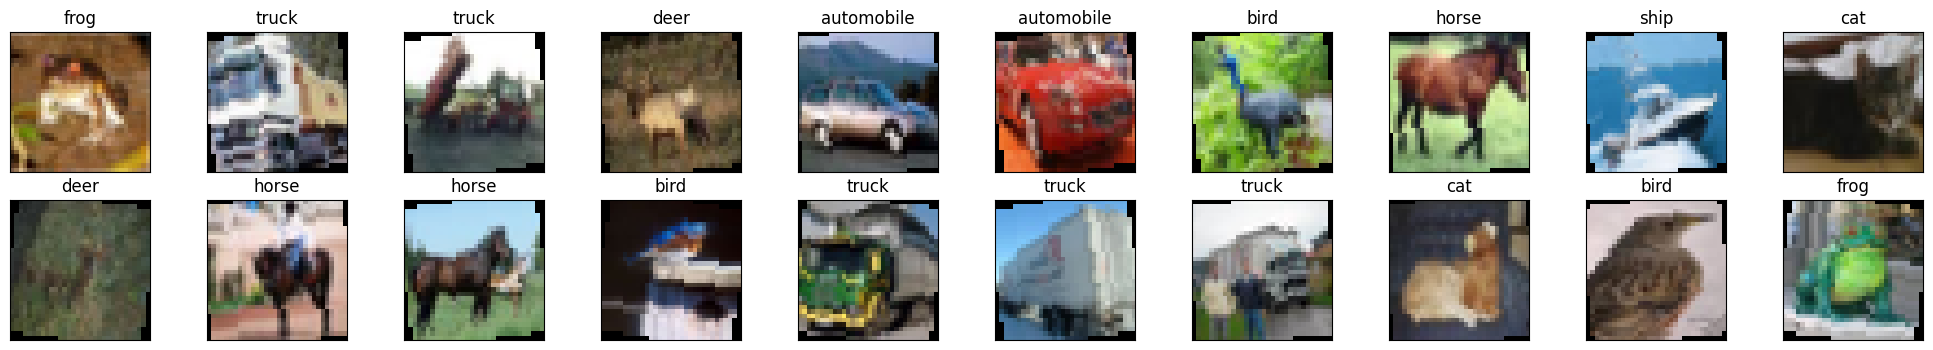

In [3]:
# Visualize a batch of training data

# Helper function to display the image
def image_show(img):
    # Un-normalize and display the image
    img = img / 2 + 0.5
    # Convert from tensor image
    plt.imshow(np.transpose(img, (1,2,0)))

# Get one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch
fig = plt.figure(figsize=(25, 4))

# Display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    image_show(images[idx])
    ax.set_title(classes[labels[idx]])

In [4]:
# Define the CNN architecture as below for size matching: cifar10 image of 3 x 32 x 32 is the input to conv1
# conv1: input = 3 x 32 x 32,  outout = 16 x 32 x 32, after pool: 16 x 16 x 16 (padding=1 is added to four image edges for conv1)
# conv2: input = 16 x 16 x 16, output = 32 x 16 x 16, after pool: 32 x 8 x 8   (padding=1 is added to four image edges for conv2)
# conv3: input = 32 x 8 x 8,   output = 64 x 8 x 8,   after pool: 64 x 4 x 4   (padding=1 is added to four image edges for conv3)
# fc1:   input = 64 x 4 x 4,   output = 500
# fc2:   input = 500,          output = 10

class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        # (i) Four consecutive convolutional layers
        # Input channels for CIFAR-10 are 3 (RGB)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=40, out_channels=60, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=60, out_channels=80, kernel_size=5, stride=1, padding=2)

        # (iii) Each convolutional layer applies AvgPool2d with size (2,2)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Calculate the input size for the first fully connected layer
        # CIFAR-10 images are 32x32.
        # After each AvgPool2d(2,2), the spatial dimensions are halved.
        # 32x32 -> 16x16 (after pool1) -> 8x8 (after pool2) -> 4x4 (after pool3) -> 2x2 (after pool4)
        # The last conv layer has 80 output channels.
        # So, input to FC layer will be 80 * 2 * 2 = 320
        self.fc1_input_features = 80 * 2 * 2

        # (iv) Three fully connected layers with output size = 500, 100, 10
        self.fc1 = nn.Linear(self.fc1_input_features, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 10) # Output layer (10 classes for CIFAR-10)

    def forward(self, x):
        # (v) All hidden layers still use F.elu as the activation function.
        # Apply conv -> elu -> pool for each convolutional block
        x = self.pool(F.elu(self.conv1(x)))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.pool(F.elu(self.conv4(x)))

        # Flatten the output for the fully connected layers
        x = x.view(-1, self.fc1_input_features) # -1 infers the batch size

        # Apply fully connected layers with F.elu for hidden layers
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = self.fc3(x) # No activation function for the output layer (implicitly handled by CrossEntropyLoss)
        return x

model = CNNNet()
print(model)

CNNNet(
  (conv1): Conv2d(3, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(40, 60, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(60, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc1): Linear(in_features=320, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [5]:
# Specify cost function and optimizer

# Specify the Cost function
criterion = nn.CrossEntropyLoss()

# Specify the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [6]:
# Train the network

# number of epochs to train the model
n_epochs = 25

for epoch in range(1, n_epochs+1):

    # keep track of training cost
    train_cost = 0.0

    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch cost
        cost = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        cost.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_cost += cost.item()*data.size(0)

    # calculate average losses
    train_cost = train_cost/len(train_loader.dataset)

    # print training/validation statistics
    print('Epoch: {} \tTraining Cost: {:.6f}'.format(epoch, train_cost))

Epoch: 1 	Training Cost: 2.078830
Epoch: 2 	Training Cost: 1.805331
Epoch: 3 	Training Cost: 1.602302
Epoch: 4 	Training Cost: 1.471465
Epoch: 5 	Training Cost: 1.389681
Epoch: 6 	Training Cost: 1.324061
Epoch: 7 	Training Cost: 1.265468
Epoch: 8 	Training Cost: 1.209083
Epoch: 9 	Training Cost: 1.156328
Epoch: 10 	Training Cost: 1.106709
Epoch: 11 	Training Cost: 1.061562
Epoch: 12 	Training Cost: 1.019439
Epoch: 13 	Training Cost: 0.981351
Epoch: 14 	Training Cost: 0.948736
Epoch: 15 	Training Cost: 0.917366
Epoch: 16 	Training Cost: 0.886119
Epoch: 17 	Training Cost: 0.854304
Epoch: 18 	Training Cost: 0.830797
Epoch: 19 	Training Cost: 0.803917
Epoch: 20 	Training Cost: 0.778531
Epoch: 21 	Training Cost: 0.755798
Epoch: 22 	Training Cost: 0.732261
Epoch: 23 	Training Cost: 0.710051
Epoch: 24 	Training Cost: 0.690367
Epoch: 25 	Training Cost: 0.670465


In [7]:
# track test cost

test_cost = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch cost
    cost = criterion(output, target)
    # update test cost
    test_cost += cost.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_cost = test_cost/len(test_loader.dataset)
print('Test Cost: {:.6f}\n'.format(test_cost))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Cost: 0.845242

Test Accuracy of airplane: 75% (755/1000)
Test Accuracy of automobile: 78% (789/1000)
Test Accuracy of  bird: 57% (574/1000)
Test Accuracy of   cat: 60% (602/1000)
Test Accuracy of  deer: 62% (626/1000)
Test Accuracy of   dog: 60% (603/1000)
Test Accuracy of  frog: 78% (782/1000)
Test Accuracy of horse: 78% (783/1000)
Test Accuracy of  ship: 79% (791/1000)
Test Accuracy of truck: 74% (740/1000)

Test Accuracy (Overall): 70% (7045/10000)
